In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy import special
from scipy.special import erf
from scipy import optimize


In [264]:
# Preprocessing
amd_quotes = pd.read_csv('amd_quotedata.csv', parse_dates=['Expiration Date'], index_col=['Expiration Date'])
amd_calls = amd_quotes.iloc[:,0:11]

S0 = 92.3
amd_calls['Strike/Spot'] = amd_calls['Strike']/S0_amd
amd_calls['Mid'] = (amd_calls['Bid']+amd_calls['Ask'])/2
C1 = amd_calls.loc['2023-04-14']
C1 = C1.reset_index(drop=True)
C1

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
0,AMD230414C00083000,9.72,-0.105,9.55,9.80,166,0.4442,0.9452,0.0172,293,83.0,0.899242,9.675
1,AMD230414C00084000,9.05,0.150,8.65,8.85,22,0.4504,0.9287,0.0217,225,84.0,0.910076,8.750
2,AMD230414C00085000,8.10,0.075,7.70,7.90,134,0.4427,0.9068,0.0272,867,85.0,0.920910,7.800
3,AMD230414C00086000,7.00,-0.125,6.80,7.00,77,0.4352,0.8782,0.0337,569,86.0,0.931744,6.900
4,AMD230414C00087000,6.20,-0.125,5.95,6.15,101,0.4259,0.8417,0.0409,544,87.0,0.942579,6.050
5,AMD230414C00088000,5.50,-0.050,5.15,5.30,192,0.4269,0.7974,0.0483,457,88.0,0.953413,5.225
6,AMD230414C00089000,4.50,-0.300,4.40,4.50,165,0.4155,0.7456,0.0556,934,89.0,0.964247,4.450
7,AMD230414C00090000,3.76,-0.340,3.70,3.80,817,0.4147,0.6869,0.0622,1864,90.0,0.975081,3.750
8,AMD230414C00091000,3.07,-0.380,3.05,3.15,1194,0.4062,0.6223,0.0677,1272,91.0,0.985915,3.100
9,AMD230414C00092000,2.50,-0.365,2.48,2.50,8647,0.4024,0.5529,0.0714,1637,92.0,0.996750,2.490


In [265]:
def iv(p,K,T,r,S0):
    """
    Calculate implied volatility using Black-Scholes formula
    
    Parameters:
    p (float): Market price(s) of the option
    K (float): Strike price(s) of the option
    T (float): Time to expiry of the option, in years
    r (float): Risk-free interest rate, as a decimal
    S0 (float): Current price of the underlying asset
    """
    
    d1 = lambda sigma: (np.log(S0/K) + (r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    d2 = lambda sigma: d1(sigma) - sigma*np.sqrt(T)
    option_price = lambda sigma: S0*norm.cdf(d1(sigma)) - K*np.exp(-r*T)*norm.cdf(d2(sigma))
    option_price_diff = lambda sigma: option_price(sigma) - p
    
    return fsolve(option_price_diff, 0.2*np.ones(len(p)))

In [266]:
# Which risk-free interest rate is used?
#iv_diff = lambda r: np.linalg.norm(iv(np.array(amd_calls_t1['Mid']),np.array(amd_calls_t1['Strike']),6/252,r,S0) - np.array(amd_calls_t1['IV']))
#r_ = minimize(iv_diff, 0.01)
#print(r_)

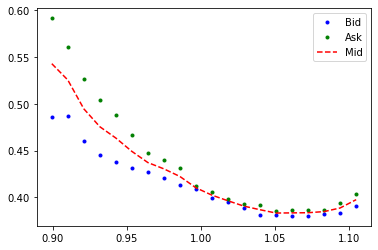

In [267]:
r = 0.01 # TODO: figure out r
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])
K = np.array(C1['Strike'])
numK = len(K)
t1 = 6/252
# Plot data
fig, ax = plt.subplots()
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,t1,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,t1,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,t1,r,S0)), 'r--', label='Mid')
plt.legend()
plt.show()

In [268]:
def sigma_objective(sigma, S0):
    sqrtt = math.sqrt(t1)
    help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)
    B_vec = 0.5*(S0-K)*erf(help_v) + sigma*sqrtt/np.sqrt(2*math.pi)*np.exp(-help_v**2)
    return np.sum((B_vec-mid)**2)


def calculate_sigma0(S_0):
    res = optimize.minimize_scalar(sigma_objective,args = (S_0,))
    return res.x

sigma0 = calculate_sigma_0(S0)
print(sigma_0)


#def m_0(s,S0,sigma0,t1): # Joint distribution of S1 and S2
    #return (S0 >= 0) *  (1/(np.sqrt(2*math.pi)*(sigma0*S0))) * np.exp(-1/2*((s-S0)/(sigma0*S0))**2)  *  (1/(np.sqrt(2*math.pi)*sigma0*S0*np.sqrt(t1)) * np.exp(-1/2*((s-S0)/(sigma0*S0*np.sqrt(t1)))**2) )

def m0(s,S_0,sigma_0,t_1):
    #renormalise m_0 on R^+
    return norm.pdf(s,S_0,sigma_0*np.sqrt(t_1))/norm.cdf(S_0/(sigma_0*np.sqrt(t_1))) if s>=0 else 0


def f1(V,omega):
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(numK)
    
    for i in range(numK):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        elif V[i]*omega[i] < delta_C_bid[i]: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f1(V,omega):
    """
    Gradient of g1 with respect to V_K
    """
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    g = np.zeros(numK)
    
    for j in range(numK):
        if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
            g[j] = V[j]*omega[j]
        elif V[j]*omega[j] > delta_C_ask[j]:
            g[j] = delta_C_ask[j]
        elif V[j]*omega[j] < delta_C_bid[j]: 
            g[j] = delta_C_bid[j]
    
    return g
    



82.26725329153062


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_13145/2763409847.py:3: RuntimeWarning: divide by zero encountered in true_divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


In [269]:
def I1(alpha,sigma,s1,K1,K2): 
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return 1/2*math.exp((alpha*sigma)**2/2 + alpha*s1) * (special.erf((B-alpha*sigma)/math.sqrt(2)) - special.erf((A-alpha*sigma)/math.sqrt(2)) )

#def I2(alpha,sigma,s1,K1,K2):
    #A, B = (K1-s1)/sigma, (K2-s1)/sigma
    #return sigma*math.exp(alpha*s1) *  (  2*math.exp(A*alpha*sigma-A*A/2) - math.sqrt(2*math.pi)*alpha*sigma*math.exp((alpha*sigma)**2/2)*special.erf((A-alpha*sigma)/math.sqrt(2)) + math.sqrt(2*math.pi)*alpha*sigma*np.exp((alpha*sigma)**2/2)*special.erf((B-alpha*sigma)/np.sqrt(2)) - 2*math.exp(alpha*B*sigma)-B**2/2  )
    
def I2(alpha,sigma,s1,K1,K2):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return sigma*math.exp(alpha*s1) * ( 2*(math.exp(A*alpha*sigma-A*A/2) - math.exp(B*alpha*sigma-B*B/2)) + math.sqrt(2*math.pi)*alpha*sigma*math.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )

def I2_quad(alpha,sigma,s1,K1,K2):
    #return 2*math.sqrt(2*math.pi) * integrate.quad(lambda s2: math.exp(alpha*s2)*(s2-s1) * (1/(math.sqrt(2*math.pi)*sigma))*math.exp(-1/2*((s2-s1)/sigma)**2), K1, K2)
    return integrate.quad(lambda s2: math.exp(alpha*s2)*(s2-s1) * (1/(math.sqrt(2*math.pi)*sigma))*math.exp(-1/2*((s2-s1)/sigma)**2), K1, K2)[0]
    
def I3(alpha,sigma,s1,K1,K2,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return math.exp(alpha*s1) *  (  2*sigma*math.exp(A*alpha*sigma-A*A/2) - math.sqrt(2*math.pi)*math.exp((alpha*sigma)**2/2)*special.erf((A-alpha*sigma)/math.sqrt(2))*(alpha*sigma**2-Q+s1) + math.sqrt(2*math.pi)*math.exp((alpha*sigma)**2/2)*special.erf((B-alpha*sigma)/math.sqrt(2))*(alpha*sigma**2-Q+s1) - 2*sigma*math.exp(alpha*B*sigma)-B**2/2  ) 

def I4(alpha,sigma,s1,K1,K2,K,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma  
    return 2*sigma* (math.exp(alpha*A*sigma-A*A/2)*(sigma*(alpha*sigma+A) - K - Q + 2*s1) + math.exp(-1/2*B*(B-2*alpha*sigma))*(-sigma*(alpha*sigma+B) + K + Q -2*s1))  +  math.sqrt(2*math.pi)*math.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/(math.sqrt(2))) - special.erf((A-alpha*sigma)/(math.sqrt(2))) ) * (sigma**2 - (-alpha*sigma**2+K-s1)*(alpha*sigma**2-Q+s1))
    


In [270]:
def I_u_integrand(s,theta,V,K,S0,sigma0,t1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m_0(s,S0,sigma0,t1)

def I_u(theta,V,K,S0,sigma0,t1):
    return integrate.quad(I_u_integrand,0,S0+3*sigma0,args=(theta,V,K,S0,sigma0,t1) )[0]



def I_h_0_integrand(s,theta,V,K,S0,sigma0,t1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m_0(s,S0,sigma0,t1)*(s-S0)

def I_h_0(theta,V,K,S0,sigma0,t1):
    return integrate.quad(I_h_0_integrand,0,S0+3*sigma0,args=(theta,V,K,S0,sigma0,t1))[0]


def I_h_0_grad_integrand(s,theta,V,K,S0,sigma0,t1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m_0(s,S0,sigma0,t1)*(s-S0)*(s-S0)
    
def I_h_0_grad(theta,V,K,S_0,sigma0,t1):
    return integrate.quad(I_h_0_grad_integrand,0,S0+3*sigma0,args=(theta,V,K,S0,sigma0,t1))[0]


def I_h_0_hessian_integrand(s,theta,V,K,S0,sigma0,t1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m0(s,S0,sigma0,t1)*(s-S0)*(s-S0)*(s-S0)

def I_h_0_hessian(theta,V,K,S0,sigma0,t1):
    return integrate.quad(I_h_0_hessian_integrand,0,S0+3*sigma0,args=(theta,V,K,S0,sigma0,t1))[0]



def I_Q_integrand(s,h0,V,K,Q,S0,sigma0,t1):
    return math.exp(-np.sum(V*np.maximum(s-K,0))+K.size*h0*(s-S0))*m_0(s,S0,sigma0,t1)*np.maximum(s-Q,0)

def I_Q(h0,V,K,Q,S0,sigma0,t1):
    return integrate.quad(I_Q_integrand,0,S0+3*sigma0,args=(h0,V,K,Q,S0,sigma0,t1))[0]
    

In [271]:
a, b, n = S0-20, S0+20, 11 # Take odd n, such that X1[(n-1)/2] = S0
K1, K2 = a, b
X1 = np.linspace(a,b,n) # Discrete grid
P1 = lambda x:(1/(np.sqrt(2*math.pi)*1e-1)) * np.exp(-1/2*((x-S0)/1e-1)**2) * (x >= 0) # Approximation of Dirac delta around 
P1_disc = lambda x: P1(x)/sum(P1(X1))
#sum(P1_disc(X1)) = 1
#sum(X1*P1_disc(X1)) = 92.3 = S0


def integrand_G1(s,V,u0,h0,K,omega,S0,sigma0,t1):
    return m_0(s,S0,sigma0,t1)*np.exp(-np.sum(V*np.maximum(s-K,0))+(u0-h0*(s-S0))*K.size) 

def G1(V,u0,h0,K,omega,S0,sigma0,t1):
    expectation = integrate.quad(integrand_G1,0,S0+3*sigma0,args=(V,u0,h0,K,omega,S0,sigma0,t1))[0]
    #expectation_other = I_u(h0,V,K,S0,sigma0,t1)*np.exp(-u0) # Gives the same result as the other one! -> Confirms P_sig0 = delta(s-S0)
    print (f'G1 = {u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation}')
    return u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation

    
def grad_G1(V,u0,h0,K,omega,S0,sigma0,t1):
    """
    Gradient of G_12 with respect to V_K_i
    """
    grad = np.zeros(numK)
    gf1 = grad_f1(V,omega)
    for i in range(numK):
        grad[i] = gf1[i] + mid[i] - I_Q(h0,V,K,K[i],S0,sigma0,t1)*np.exp(-u0) # Q = K[i] #TODO: can this be sped up by providing Q as a vector?
    
    print(f'Grad = {grad}')
    #print(f'Grad norm = {np.norm(grad)}')
    return grad


def Hess_G1(V,u0,h0,K,omega,S0,sigma0,t1):
    '''
    Hessian of G_12
    '''
    H = np.zeros((numK,numK))
    H = np.diag(omega)
    
    for i in range(numK):
        for j in range(numK):
            integrand = lambda s: np.maximum((s-K[i]),0)*np.maximum((s-K[j]),0)*np.exp(-np.sum(V*np.maximum(s-K,0))+(u0-h0*(s-S0))*K.size)*m_0(s,S0,sigma0,t1)
            H[i,j] += integrate.quad(integrand,0,S0+3*sigma0)[0] 
    
    return H

    
    

In [272]:
def grad_G1_comparison(V,u0,h0,K,omega,S0,sigma0,t1):
    '''
    Check whether the expression of the gradient is correct, by comparing it to a finite difference approximation
    '''
    grad = grad_G1(V,u0,h0,K,omega,S0,sigma0,t1)
    
    grad_FD = np.zeros(numK)
    eps = 1e-7
    for i in range(numK):
        D = np.zeros(numK)
        D[i] = eps
        grad_FD[i] = (G1(V+D,u0,h0,K,omega,S0,sigma0,t1)-G1(V,u0,h0,K,omega,S0,sigma0,t1))/eps
        
    print(f'Grad = {grad}')
    print(f'Grad_FD = {grad_FD}')

u0, h0, V = 0., 0., [0.]*numK
p0 = np.array([u1] + [h1] + V)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)

grad_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,sigma0,t1)




Grad = [-1.34061779 -1.50975514 -1.72926395 -1.92540119 -2.09931341 -2.27701746
 -2.43438296 -2.54711697 -2.64075125 -2.72563246 -2.75191605 -2.72956306
 -2.66834106 -2.56282833 -2.42742167 -2.25634733 -2.0736748  -1.88333314
 -1.68912927 -1.49476767]
G1 = 0.9999998658781437
G1 = 1.0000000000000002
G1 = 0.9999998489698612
G1 = 1.0000000000000002
G1 = 0.999999827054272
G1 = 1.0000000000000002
G1 = 0.9999998074784152
G1 = 1.0000000000000002
G1 = 0.9999997898662669
G1 = 1.0000000000000002
G1 = 0.9999997722176321
G1 = 1.0000000000000002
G1 = 0.9999997566011457
G1 = 1.0000000000000002
G1 = 0.9999997449830005
G1 = 1.0000000000000002
G1 = 0.9999997358212679
G1 = 1.0000000000000002
G1 = 0.9999997275316914
G1 = 1.0000000000000002
G1 = 0.9999997240960921
G1 = 1.0000000000000002
G1 = 0.9999997286604975
G1 = 1.0000000000000002
G1 = 0.9999997324213349
G1 = 1.0000000000000002
G1 = 0.9999997433374712
G1 = 1.0000000000000002
G1 = 0.9999997584325798
G1 = 1.0000000000000002
G1 = 0.999999773418854
G1 = 1

In [273]:
def Hess_G1_comparison(V,u0,h0,K,omega,S0,sigma0,t1):
    '''
    Check whether the expression of the Hessian is correct, by comparing it to a finite difference approximation
    '''
    Hess = Hess_G1(V,u0,h0,K,omega,S0,sigma0,t1)
    u = np.ones(numK)
    eps = 1e-7
    
    Hess_u = Hess.dot(u)
    Hess_u_FD = (grad_G1(V+eps*u,u0,h0,K,omega,S0,sigma0,t1)-grad_G1(V,u0,h0,K,omega,S0,sigma0,t1))/eps
    
    print(f'Hess_u = {Hess_u}')
    print(f'Hess_u_FD = {Hess_u_FD}')
    

Hess_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,sigma0,t1)

Grad = [-1.3403567  -1.50950499 -1.72902475 -1.92517293 -2.09909606 -2.27681099
 -2.43418734 -2.54693212 -2.64057709 -2.72546888 -2.7517629  -2.72942018
 -2.66820822 -2.56270531 -2.4273082  -2.25624308 -2.07357945 -1.88324631
 -1.68905055 -1.49469664]
Grad = [-1.34061779 -1.50975514 -1.72926395 -1.92540119 -2.09931341 -2.27701746
 -2.43438296 -2.54711697 -2.64075125 -2.72563246 -2.75191605 -2.72956306
 -2.66834106 -2.56282833 -2.42742167 -2.25634733 -2.0736748  -1.88333314
 -1.68912927 -1.49476767]
Hess_u = [2610.84374531 2501.40628915 2392.00375867 2282.68605244 2173.54025761
 2064.68288675 1956.27610316 1848.51779219 1741.63038986 1635.86543637
 1531.52891453 1428.91837048 1328.369025   1230.22204964 1134.81218868
 1042.48804131  953.5742498   868.37788873  787.18332283  710.23579343]
Hess_u_FD = [2610.91606506 2501.47065092 2391.96977626 2282.65307657 2173.50828658
 2064.65191915 1956.24610155 1848.48876859 1741.60213697 1635.83826286
 1531.50275129 1428.8933139  1328.3450709  1230.

In [274]:
#xx = np.linspace(-0.1,0.1,400)
#g = lambda x: I_h_0(x,V,K,S0,sigma_0,t1)
#g_ = np.vectorize(g)
#plt.plot(xx,g_(xx))

In [ ]:
h0 = optimize.root_scalar(I_h_0,args=(V,K,S0,sigma0,t1) ,bracket = [-1,1],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
#u1 = -math.log(1/(I_u(h1,V,K,s1,sigma_0,t1)))
u0 = np.log(I_u(h0,V,K,S0,sigma0,t1))
print(h0)
print(u0)
    

V_star = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
print(V_star)
    
    
    
    

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_13145/2347683137.py:10: RuntimeWarning: overflow encountered in exp
  return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m_0(s,S0,sigma0,t1)*(s-S0)


0.0
2.2204460492503128e-16
G1 = 1.000000000000005


/Users/jeroen/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:527: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  if not isinstance(args, tuple):


Grad = [-1.34061779 -1.50975514 -1.72926395 -1.92540119 -2.09931341 -2.27701746
 -2.43438296 -2.54711697 -2.64075125 -2.72563246 -2.75191605 -2.72956306
 -2.66834106 -2.56282833 -2.42742167 -2.25634733 -2.0736748  -1.88333314
 -1.68912927 -1.49476767]


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_13145/1804031541.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  expectation = integrate.quad(integrand_G1,0,S0+3*sigma0,args=(V,u0,h0,K,omega,S0,sigma0,t1))[0]


G1 = 13.65175106848102


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_13145/2347683137.py:35: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(I_Q_integrand,0,S0+3*sigma0,args=(h0,V,K,Q,S0,sigma0,t1))[0]


Grad = [9.54175135 8.67672889 7.80349639 6.90389296 6.05424459 5.22845292
 4.45246104 3.752575   3.10266966 2.49055109 1.97111282 1.53055189
 1.16053951 0.86629544 0.6304908  0.46045621 0.33041928 0.2351904
 0.17034152 0.13030223]
G1 = 2.107242068008423
Grad = [8.54776899 7.83216249 7.06678261 6.32622765 5.61088317 4.89671862
 4.21062634 3.58009676 2.98269595 2.41102293 1.91851043 1.49729186
 1.13983131 0.85300096 0.62293962 0.45598448 0.32777302 0.23377151
 0.16936446 0.12967429]


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_13145/1804031541.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expectation = integrate.quad(integrand_G1,0,S0+3*sigma0,args=(V,u0,h0,K,omega,S0,sigma0,t1))[0]


G1 = 0.9905540553734071


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_13145/2347683137.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(I_Q_integrand,0,S0+3*sigma0,args=(h0,V,K,Q,S0,sigma0,t1))[0]


Grad = [ 4.74791003  4.2976698   3.79715794  3.32026261  2.86610762  2.40905109
  1.97377476  1.58527434  1.21880775  0.86492574  0.57461805  0.3389688
  0.1494072   0.01252098 -0.08501694 -0.13635456 -0.16467019 -0.17314464
 -0.16499827 -0.14356235]
G1 = 0.9717182375832676
Grad = [ 4.629809    4.19158179  3.70302738  3.23796012  2.79538975  2.34953596
  1.9249249   1.54640087  1.18908131  0.84339312  0.56025438  0.33069388
  0.14614365  0.01323027 -0.08131103 -0.13051838 -0.15745553 -0.16517742
 -0.15677437 -0.13545962]
G1 = 0.9015429474373842
Grad = [ 4.08981943  3.70481015  3.26925045  2.85665344  2.46555579  2.06959488
  1.69262154  1.35880566  1.04262338  0.7339189   0.48324589  0.28135255
  0.11965042  0.00492193 -0.07581697 -0.11510844 -0.13548498 -0.13941883
 -0.12940397 -0.10811469]
G1 = 0.7624153863495013
Grad = [ 2.41742876  2.22419082  1.97977225  1.755923    1.54891048  1.32962514
  1.11825134  0.93528266  0.75181177  0.55464931  0.39283862  0.25672928
  0.13964817  0.0515